# **TP3 - Grupo 4**
Pedro Paulo Costa Pereira - A88062

Tiago Andr√© Oliveira Leite - A91693

# **Problema - Sistema de Travagem ABS**
No contexto do sistema de travagem ABS (‚ÄúAnti-Lock Breaking System‚Äù), pretende-se construir um aut√≥mato h√≠brido que descreva o sistema e que  possa ser usado para verificar as suas propriedades din√¢micas.

    
1. A componente discreta do aut√≥mato cont√©m os modos:  `Start`,  `Free`,  `Stopping`, `Blocked`, e `Stopped`. No modo `Free`  n√£o existe qualquer for√ßa de travagem; no modo `Stopping` aplica-se a for√ßa de travagem alta; no modo `Blocked` as rodas est√£o bloqueadas em rela√ß√£o ao corpo mas o ve√≠culo  desloca-se; no modo `Stopped` o ve√≠culo est√° imobilizado.


2. A componente cont√≠nua  do aut√≥mato usa vari√°veis cont√≠nuas $\,V,v\,$ para descrever a  `velocidade do corpo`  do ve√≠culo em rela√ß√£o ao solo e a `velocidade linear das rodas` tamb√©m em rela√ß√£o ao solo. 
    Assume-se que o sistema de travagem exerce uma for√ßa de atrito  nos trav√µes proporcional √† diferen√ßa das duas velocidades.  A din√¢mica cont√≠nua est√° descrita  abaixo no bloco Equa√ßoes de Fluxo.


3. Os ‚Äúswitchs‚Äù (‚Äújumps‚Äù) s√£o a componente de projeto deste trabalho; cabe ao aluno definir quais devem ser estas  condi√ß√µes de modo a que o sistema tenha um comportamento desej√°vel: imobilize-se depressa e n√£o ‚Äúderrape‚Äù muito.


4. Fa√ßa
    1. Defina um aut√≥mato h√≠brido que descreva a din√¢mica do sistema segundo as notas abaixo indicadas e com os ‚Äúswitchs‚Äù por si escolhidos.
    2. Modele em l√≥gica temporal linear LT  propriedades que caracterizam o comportamento desej√°vel do sistema. Nomeadamente 
        1. ‚Äùo ve√≠culo imobiliza-se completamente em menos de $t$ segundos‚Äù 
        2. ‚Äúa velocidade $V$ diminui sempre com o tempo‚Äù.
    3. Codifique em SMT‚Äôs o modelo que definiu em a.
    4. Codifique a verifica√ß√£o das propriedades temporais que definiu em b.

<img src="e.png" style="width:700px;height:400px"/>

**Equa√ß√µes de Fluxo** 

1. Durante  a travagem n√£o existe qualquer  for√ßa no sistema excepto as for√ßas de atrito. Quando uma superf√≠cie se desloca em rela√ß√£o √† outra, a for√ßa de atrito  √© proporcional √† for√ßa de compress√£o entre elas. 
2. No contacto rodas/solo o atrito √© constante porque a for√ßa de compress√£o √© o peso; tem-se $f = a\cdot P$ sendo  $a$ a constante de atrito e $P$ o peso. Ambos s√£o fixos e independentes do modo.
3. No contacto corpo/rodas,  a for√ßa de compress√£o √© a for√ßa de travagem que aqui se assume como proporcional √† diferen√ßa de velocidades  $F =  c\cdot (V-v)$.  A  constante de proporcionalidade $c$ depende do modo: √© elevada no modo `Stopping` e baixa nos outros.
4. Existe um atrito no contacto corpo/ar  que √© aproximado por uma constante positiva $\,b$.
5. As equa√ß√µes que traduzem a din√¢mica  do sistema s√£o, em todos os modo excepto `Blocked`,

$$\begin{array}{c} \dot{V} & = & - c\cdot(V-v) - b\\ \dot{v} & = & -a\cdot P  + c\cdot(V-v) \end{array}$$   

e , no modo `Blocked`,  a din√¢mica do sistema √©  regida por

$$
\begin{array}{c} (V = v) \;\land\; (\,\dot{V}\,=\, -a\cdot P - b\,) \end{array} $$


6. Tanto no modo `Blocked`  como no modo `Free`  existe um ‚Äútimer‚Äù que impede que se permane√ßa nesses modo mais do que $\,\tau\,$segundos. Os $\mathsf{jumps}(V,v,t,V',v',t')\,$ com origem nesses modos devem for√ßar esta condi√ß√£o.
7. No instante inicial assume-se $\,V = v\,=\,V_0$  ,  em que a velocidade $V_0$ √© o ‚Äúinput‚Äù do problema.

## Constantes e variaveis  do sistema
**Constantes:**<br>
> $a$ ‚ü∂ atrito do ar<br>
> $b$ ‚ü∂ atrito do solo<br>
> $c1$ ‚ü∂ constante de proporcionalidade na travagem do modo `Free`<br>
> $c2$ ‚ü∂ constante de proporcionalidade na travagem do modo `Stopping`<br>
> $e$ ‚ü∂ $Min(V - R)$ do modo `Stopping` que quando ultrapassado obriga √† transi√ß√£o de modo e tambem $Min(V) \land\ Min(R)$ que quando atingido em simultaneo permite transitar para o modo `Stopped`
<br>
> $P$ ‚ü∂ peso em kilogramas do ve√≠culo<br>
> $tau \ (œÑ)$ ‚ü∂ tempo em segundos de cada execu√ß√£o dos modos `Blocked` e `Free`<br>
> $time$ ‚ü∂ tempo maximo em segundos at√© o ve√≠culo se imobilizar<br>
> $vi$ ‚ü∂ velocidade inicial do ve√≠culo em metros/segundo



**Variaveis continuas:**<br>
> $T$ ‚ü∂ tempo em segundos<br>
> $V$ ‚ü∂ velocidade do veiculo em metros/segundo<br>
> $R$ ‚ü∂ velocidade das rodas em metros/segundo(v)<br>
> $Timer$ ‚ü∂ Timer utilizado nos modos Free e Blocked

**Variaveis Discretas:**<br>
> $M$ ‚ü∂ Modo



In [1]:
from z3 import *
import pygraphviz as pgv
from IPython.display import Image 
import matplotlib.pyplot as plt

## A. Aut√≥mato h√≠brido que descreve a din√¢mica do sistema

### Fun√ß√£o para desenhar o aut√≥mato

In [2]:
def draw(dot):
    return Image(pgv.AGraph(dot).draw(format='png', prog='dot'))

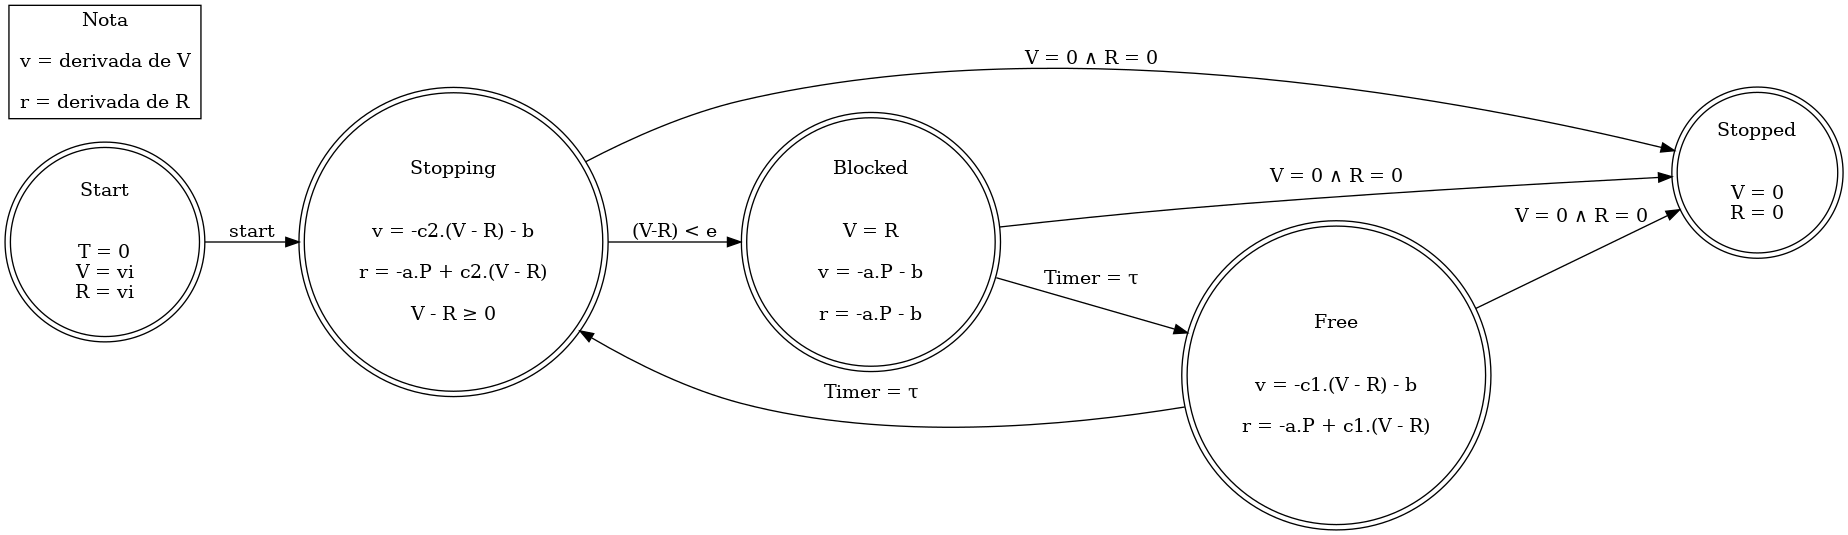

In [3]:
ABS = """digraph{
    rankdir=LR;
    Start [shape=doublecircle, label="Start\n\n\nT = 0\nV = vi\nR = vi"];
    Free [shape = doublecircle, label="Free\n\n\nv = -c1.(V - R) - b\n\nr = -a.P + c1.(V - R)"];
    Stopping [shape = doublecircle, label="Stopping\n\n\nv = -c2.(V - R) - b\n\nr = -a.P + c2.(V - R)\n\nV - R ‚â• 0"];
    Blocked [shape = doublecircle, label="Blocked\n\n\nV = R\n\nv = -a.P - b\n\nr = -a.P - b"];
    Stopped [shape = doublecircle, label="Stopped\n\n\nV = 0\nR = 0"];
    
    Nota [shape=box, label="Nota\n\nv = derivada de V\n\nr = derivada de R"];
  
    Start -> Stopping[label="start"];
    Free -> Stopping [label="Timer = œÑ"];
    Stopping -> Blocked[label="(V-R) < e"];
    Stopping -> Stopped[label="V = 0 ‚àß R = 0"];
    Blocked -> Free [label="Timer = œÑ"];
    Blocked -> Stopped[label="V = 0 ‚àß R = 0"];
    Free -> Stopped[label="V = 0 ‚àß R = 0"];  
}"""

draw(ABS)

## B. Modela√ß√£o em LT das propriedades que garantem comportameneto desej√°vel
### a. ‚Äùo ve√≠culo imobiliza-se completamente em menos de $t$ segundos‚Äù.<br>
> $T \ge t \quad \implies\ \quad M = Stopped$

### b. ‚Äúa velocidade $V$ diminui sempre com o tempo‚Äù.
> $ t' > t \quad \implies\ \quad V' < V$


## Codifica√ß√£o do Modelo

### Enumera√ß√£o dos modos

In [4]:
Mode,(START, FREE, STOPPING, BLOCKED, STOPPED) = EnumSort('Mode', ('START','FREE','STOPPING', 'BLOCKED','STOPPED'))

### Fun√ß√£o que mostra o grafico de evolu√ß√£o do sistema em fun√ß√£o das constantes

Nesta fun√ß√£o √© feita uma simula√ß√£o de execu√ß√£o do sistema com base nas equa√ß√µes fornecidas no enunciado e com o valor das constantes escolhido pelo utilizador.<br>

No final √© imprimido um gr√°fico que premite avaliar, com base no comportamento das variaveis que representam a velocidade do ve√≠culo e a velocidade das rodas ao longo do tempo, se o valor escolhido para as constantes √© aceitav√©l ou n√£o.

In [5]:
def simulation(a, b, c1, c2, dt, e, P, tau, time, vi):
    v = vi
    r = vi
    t = 0
    V = [v]
    R = [r]
    T = [t]
    timer = 0
    m = STOPPING
    
    while(t<time and (v>0 or r>0)):
        
        if m == STOPPING and (v - r <= e )  :
            m = BLOCKED
        
        elif timer >= tau and m == BLOCKED:
            m = FREE
            timer = 0
        
        elif timer >= tau and m == FREE:
            m = STOPPING
            timer = 0 
        
        
        if m == FREE:
            v,r  = v +(-c1*(v-r)-b)*dt, r + (-a*P + c1 *(v-r))*dt
        
        elif m == STOPPING:
            v,r  = v +(-c2*(v-r)-b)*dt, r + (-a*P + c2 *(v-r))*dt
        
        else:
            v,r = v +(-a*P-b)*dt, r  + (-a*P-b)*dt 
    
        
        t += dt
        timer += dt
        V.append(v)
        R.append(r)
        T.append(t)
        
    
    plt.plot(T,V,T,R)
    plt.title("Velocidade / Tempo")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Velocidade (m/s)")
    plt.legend(["Veiculo", "Rodas"], loc ="upper right")
    plt.grid(True)

### Escolha de valores para as constantes

In [6]:
a = 0.01
b = 0.5
c1 = 0.5
c2 = 7
dt = 0.1
e = 0.5
P = 1000
tau = 0.3
time = 20
vi = 20

### Gr√°fico de evolu√ß√£o do sistema com as constantes escolhidas

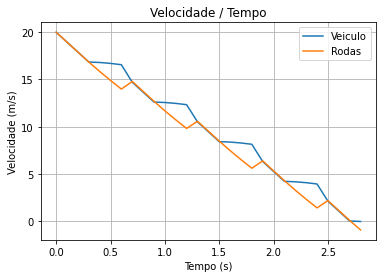

In [7]:
simulation(a, b, c1, c2, dt, e, P, tau, time, vi)

### Fun√ß√£o que declara as variaveis de cada estado

As vari√°veis s√£o guardadas guardadas num dicionario $s$.
Sendo que representam:
> $s['T']$ ‚ü∂ uma vari√°vel real com o tempo de execu√ß√£o do sistema;<br>
> $s['V']$ ‚ü∂ uma vari√°vel real com o a velocidade do ve√≠culo;<br>
> $s['R']$ ‚ü∂ uma vari√°vel real com o a velocidade das rodas;<br>
> $s['M']$ ‚ü∂ uma constante que indica o modo do ve√≠culo (`Start`,  `Free`,  `Stopping`, `Blocked`, `Stopped`)<br>
> $s['Timer']$ ‚ü∂ uma variav√©l real, utilizada nos modos `Free` e `Blocked`, para controlar o tempo de permanencia no modo.

In [8]:
def declare(i):
    s = {}
    s['T'] = Real('T'+str(i)) # tempo
    s['V'] = Real('V'+str(i)) # velociadae veiculo
    s['R'] = Real('R'+str(i)) # velocidade rodas
    s['M'] = Const('M'+str(i),Mode) # modo
    s['Timer'] = Real('Timer'+str(i))
    return s

### Fun√ß√£o que adiciona as restri√ß√µes do estado inicial

As restri√ß√µes no estado inicial s√£o:
> $T = 0 \quad \land\ \quad V = R = vi \quad \land\ \quad M = START$


In [9]:
def init(s):
    return And(s['T'] == 0, s['V'] == vi, s['R'] == vi, s['M'] == START) 

### Fun√ß√£o que adiciona as restri√ß√µes associadas a cada transi√ß√£o

Nesta fun√ß√£o vamos definir as restri√ß√µes para as transi√ß√µes entre os v√°rios estados.<br>
Em primeiro lugar podemos divir as transi√ß√µes em dois grupos, ***timed*** e ***untimed***. Nas ***timed*** ocorre passagem de tempo e corresponde √†s transi√ß√£oes de um estado para ele pr√≥prio, enquanto que nas transi√ß√µes ***untimed*** n√£o ocorre passagem do tempo, correspondendo por isso a transi√ß√µes entre estados. A √∫nica excep√ß√£o √© a transi√ß√£o `Stopped` $ ‚ü∂ $ `Stopped` que vai ser uma transi√ß√£o "untimed" apesar de ser uma transi√ß√£o de um estado para ele pr√≥prio.<br>

**Transi√ß√µes** ***untimed:***

- `Start` $ ‚ü∂ $ `Stopping` <br>
> $M = START \land\ M' = STOPPING \land\ T = T' \land\ V = V' \land\ R = R'$ 
- `Stopping` $ ‚ü∂ $ `Blocked` <br>
> $M = STOPPING \land\ M' = BLOCKED \land\ T = T' \land\ V = V' \land\ R = R' \land\ V > 0 \land\ R \ge 0 \land\ V - R < e \land\ Timer' = 0$
- `Blocked` $ ‚ü∂ $ `Free` <br>
> $M = BLOCKED \land\ M' = FREE \land\ T = T' \land\ V = V' \land\ R = R' \land\ V > 0 \land\ R \ge 0 \land\ Timer \ge tau \land\ Timer' = 0 $

**Nota:** A transi√ß√£o pode acontecer quando $Timer \ge tau$ em vez de $Timer = tau$ por causa de possiveis erros de arredondamento inerentes ao python.

- `Free` $ ‚ü∂ $ `Stopping` <br>
> $M = FREE \land\ M' = STOPPING \land\ T = T' \land\ V = V' \land\ R = R' \land\ V > 0 \land\ R \ge 0 \land\ Timer \ge tau$

**Nota:** A transi√ß√£o pode acontecer quando $Timer \ge tau$ em vez de $Timer = tau$ por causa de possiveis erros de arredondamento inerentes ao python.<br>

- `Stopping` $ ‚ü∂ $ `Stopped` <br>
> $M = STOPPING \land\ M' = STOPPED \land\ T = T' \land\ V' = 0 \land\ R' = 0 \land\ V < e \land\ R < e$<br>

**Nota:** A transi√ß√£o pode acontecer com $V > 0 \vee R > 0$ porque as restri√ß√µes inerentes √† transi√ß√£o `Stopping` $ ‚ü∂ $ 
`Stopping` podem impedir que V e R atingam em simultaneoo valor 0 no estado `Stopping`.

- `Blocked` $ ‚ü∂ $ `Stopped` <br>
> $M = BLOCKED \land\ M' = STOPPED \land\ T = T' \land\ V' = 0 \land\ R' = 0 \land\ V < e \land\ R < e$<br>

**Nota:** A transi√ß√£o pode acontecer com $V > 0 \vee R > 0$ porque as restri√ß√µes inerentes √† transi√ß√£o `Blocked` $ ‚ü∂ $ 
`Blocked` podem impedir que V e R atingam em simultaneo o valor 0 no estado `Blocked`.
- `Free` $ ‚ü∂ $ `Stopped` <br>

> $M = FREE \land\ M' = STOPPED \land\ T = T' \land\ V' = 0 \land\ R' = 0 \land\ V < e \land\ R < e$<br>


**Nota:** A transi√ß√£o pode acontecer com $V > 0 \vee R > 0$ porque as restri√ß√µes inerentes √† transi√ß√£o `Free` $ ‚ü∂ $ 
`Free` podem impedir que V e R atingam em simultaneo o valor 0 no estado `Free`.


- `Stopped` $ ‚ü∂ $ `Stopped` <br>
> $M = STOPPED \land\ M' = STOPPED \land\ T = T' \land\ V = V' \land\ R = R'$<br>

**Transi√ß√µes** ***timed:***

- `Blocked` $ ‚ü∂ $ `Blocked` <br>
> $M = BLOCKED \land\ M' = STOPPED \land\ T < T' \land\ V \ge 0 \land\ V' \ge 0  \land\ R \ge 0 \land\ R' \ge 0 \land Timer' = Timer + T' - T \land\ Timer' \le tau \land\ V' = V + (-a \times P - b) \times (T' - T) 
\land\ R' = R + (-a \times P - b) \times (T' - T) $<br>

Nas duas transi√ß√µes restantes, para evitar a multiplica√ß√£o de vari√°veis, temos que proceder √† discretiza√ß√£o do valor de $(V - R)$. 
Ora, como ao longo do tempo a velocidade do ve√≠culo decresce sempre  e $V \ge R$ ent√£o, sabemos que $(V - R)$ √© sempre inferior √† velocidade inicial (**vi**) do ve√≠culo. Por outro lado, como o ve√≠culo eventualmente vai ficar imobilizado ent√£o, $(V - R) \ge 0$. Podemos assim conluir que:
> $0 \le (V - R) \le vi$

Assim sendo podemos dividir as ultimas duas transi√ß√µes em varias subtransi√ß√µes, com uma granularidade no intervalo:
> $[0,1,2,..vi]$

Podemos ent√£o utilizar os valores deste intervalo em substitui√ß√£o do valor $(V - R)$. Para sabermos que valor do intervalo utilizar, basta verificar o valor em $(V - R)$ e arredondar para o valor mais pr√≥ximo pretencente ao intervalo.<br>
Seja $G = [0,1,2,..vi]$
- `Stopping` $ ‚ü∂ $ `Stopping` <br>
> $ \bigvee_{i \ \in \ G} \ (M = STOPPING \land\ M' = STOPPING \land\ T < T' \land\ V - R \ge e 
\land\ V' - R' \ge 0 \land\ V \ge 0 \land\ V' \ge 0 \land\ R \ge 0 \land\ R' \ge 0 \land\ V - R < i + 0.5 
\land\ V - R \ge i - 0.5 \land\ V' = V + (-c2 \times i - b) \times (T' - T) 
\land\ R' = R + (-a \times P + c2 \times i) \times (T' - T))$
- `Free` $ ‚ü∂ $ `Free` <br>
> $ \bigvee_{i \ \in \ G} \ (M = FREE \land\ M' = FREE \land\ T < T' \land\ Timer' = Timer + T' - T\land\ 
Timer' \le tau \land\ V \ge 0 \land\ V' \ge 0 \land\ R \ge 0 \land\ R' \ge 0 \land\ V - R < i + 0.5 
\land\ V - R \ge i - 0.5 \land\ V' = V + (-c1 \times i - b) \times (T' - T) \land\ R' = R + (-a \times P + c1 \times i) \times (T' - T))$  
 
Seja $\ trans = [t_0,..,t_{i}]$, o conjunto de todas as transi√ß√µes definidas em cima.<br>

O resultado final √©:
> $\bigvee_{i \ \in \ trans} t_i$



In [10]:
def trans(s,p):
    granularidade = [i for i in range(vi+1)]
    
    #untimed
    
    
    start2stopping = And(s['M']==START, p['M']==STOPPING ,s['T']==p['T'], s['V']==p['V'], s['R']==p['R'])
    
    
    stopping2blocked = And(s['M']==STOPPING, p['M']==BLOCKED ,s['T']==p['T'],s['V']>0,s['R']>=0, 
                           s['V']==p['V'], s['R']==p['R'], p['Timer']==0, s['V']-s['R']<e)
    
    blocked2free = And(s['M']==BLOCKED, p['M']==FREE ,s['T']==p['T'],s['V']>0,s['R']>=0, 
                       s['V']==p['V'], s['R']==p['R'], s['Timer']>=tau, 
                       p['Timer']==0)
    
    
    free2stopping  =  And(s['M']==FREE, p['M']==STOPPING ,s['T']==p['T'], s['V']>0,s['R']>=0, 
                          s['V']==p['V'], s['R']==p['R'], s['Timer']>=tau)
    
    
    stopping2stopped = And(s['M']==STOPPING, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']<e, s['R']<e, p['V'] == 0, p['R'] == 0)
    
    free2stopped = And(s['M']==FREE, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']<e, s['R']<e, p['V'] == 0, p['R'] == 0)
    
    blocked2stopped = And(s['M']==BLOCKED, p['M']==STOPPED ,s['T']==p['T'],
                           s['V']<e, s['R']<e, p['V'] == 0, p['R'] == 0)
    
    stopped2stopped = And(s['M']==STOPPED, p['M']==STOPPED, s['T'] == p['T'], 
                          s['V']==p['V'], s['R']== p['R'])
    
    
    
    #timed
    
    
    stopping2stopping = Or([And(s['M']==STOPPING,p['M']==STOPPING,p['T']>s['T'],
                        s['V']-s['R']>=e, 
                        p['V']-p['R']>=0,   
                        s['V']>=0,s['R']>=0, 
                        p['V']>=0, p['R']>=0,
                        s['V']-s['R']<i+0.5, s['V']-s['R']>=i-0.5, 
                        p['V']==(s['V']+(-c2*i-b)*(p['T']-s['T'])),
                        p['R']==(s['R']+(-a*P + c2*i)*(p['T']-s['T'])))for i in granularidade])
    
    
    
    free2free = Or([And(s['M']==FREE,p['M']==FREE,p['T']>s['T'], s['V']>=0,s['R']>=0,
                        p['V']>=0, p['R']>=0, 
                        p['Timer']<=tau,p['Timer']==s['Timer']+p['T']-s['T'], 
                        s['V']-s['R']<i+0.5, s['V']-s['R']>=i-0.5, 
                        p['V']==(s['V']+(-c1*i-b)*(p['T']-s['T'])),
                        p['R']==(s['R']+(-a*P + c1*i)*(p['T']-s['T'])))for i in granularidade])
    
    blocked2blocked = And(s['M']==BLOCKED,p['M']==BLOCKED,p['T']>s['T'],s['V']>=0,s['R']>=0,
                          p['V']>=0, p['R']>=0, 
                          p['Timer']<=tau,p['Timer']==s['Timer']+p['T']-s['T'],
                          p['V'] == s['V'] + (-a*P -b)*(p['T']-s['T']), 
                          p['R'] == s['R'] + (-a*P -b)*(p['T']-s['T'])) 
                          
    
    
    return Or( start2stopping, 
              stopping2blocked, blocked2free, free2stopping, stopping2stopped, free2stopped, blocked2stopped,
              stopping2stopping, free2free, blocked2blocked, stopped2stopped )

### Fun√ß√£o que gera um tra√ßo de execu√ß√£o do sistema com k estados

A fun√ß√£o vai simular, atrav√™s do solver Z3, uma execu√ß√£o do sistema com **k** estados, $[E_0 .. E_{k-1}]$, e **k-1** transi√ß√µes, com as restri√ß√µes codificadas anteriormente. Sendo $E_0$ o estado inicial. 

Caso o sistema seja satisfazivel, v√£o ser imprimidas, estado a estado, os valores das vari√°veis do sistema.

In [11]:
def gera_traco(declare,init,trans, k):
    s = Solver()
    traco = {}
    for i in range(k):
        traco[i] = declare(i)
    s.add(init(traco[0]))
    for i in range(k-1):
        s.add(trans(traco[i],traco[i+1]))
    status = s.check()
    if status == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in traco[i]:
                if v!= "Timer":
                    if traco[i][v].sort() == RealSort():
                        print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                    else:
                        print(v,"=",m[traco[i][v]])
    elif status == unsat:
        print("N√£o ha execu√ß√µes possiveis")
    else:
        print("Resultado impossivel de obter!")

In [175]:
gera_traco(declare,init,trans,10)

0
T = 0.0
V = 20.0
R = 20.0
M = START
1
T = 0.0
V = 20.0
R = 20.0
M = STOPPING
2
T = 0.0
V = 20.0
R = 20.0
M = BLOCKED
3
T = 0.3
V = 16.85
R = 16.85
M = BLOCKED
4
T = 0.3
V = 16.85
R = 16.85
M = FREE
5
T = 0.6
V = 16.7
R = 13.85
M = FREE
6
T = 0.6
V = 16.7
R = 13.85
M = STOPPING
7
T = 0.610940170940171
V = 16.464786324786324
R = 13.97034188034188
M = STOPPING
8
T = 0.7190482790482791
V = 14.897218757218758
R = 14.402774312774312
M = STOPPING
9
T = 0.7190482790482791
V = 14.897218757218758
R = 14.402774312774312
M = BLOCKED


### Fun√ß√£o que gera um tra√ßo de execu√ß√£o do sistema com k estados e com garantia que o autom√≥vel se imobiliza

A fun√ß√£o √© praticamente igual √† fun√ß√£o ***gera_traco***, definida anteriormente, sendo que nesta vai ser adicionada a seguinte restri√ß√£o ao estado final ($E_{k-1}$):
> $M = STOPPED$

Para que o resultado de execu√ß√£o da fun√ß√£o seja satisfazivel, temos que ir testando para v√°rios valores de **k**, uma vez que para um valor de **k** demasiado pequeno, o n√∫mero de estados disponivies pode ser insuficiente para conseguir imobilizar o ve√≠culo.

In [12]:
def gera_traco_stopped(declare,init,trans, k):
    s = Solver()
    traco = {}
    for i in range(k):
        traco[i] = declare(i)
    s.add(init(traco[0]))
    for i in range(k-1):
        s.add(trans(traco[i],traco[i+1]))
    s.add(traco[k-1]['M']==STOPPED) 
    status = s.check()
    if status == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in traco[i]:
                if v!= "Timer":
                    if traco[i][v].sort() == RealSort():
                        print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                    else:
                        print(v,"=",m[traco[i][v]])
    elif status == unsat:
        print("N√£o ha execu√ß√µes possiveis")
    else:
        print("Resultado impossivel de obter!")

In [179]:
gera_traco_stopped(declare,init,trans,30)

0
T = 0.0
V = 20.0
R = 20.0
M = START
1
T = 0.0
V = 20.0
R = 20.0
M = STOPPING
2
T = 0.0
V = 20.0
R = 20.0
M = BLOCKED
3
T = 0.3
V = 16.85
R = 16.85
M = BLOCKED
4
T = 0.3
V = 16.85
R = 16.85
M = FREE
5
T = 0.6
V = 16.7
R = 13.85
M = FREE
6
T = 0.6
V = 16.7
R = 13.85
M = STOPPING
7
T = 0.6876923076923077
V = 14.814615384615385
R = 14.814615384615385
M = STOPPING
8
T = 0.6876923076923077
V = 14.814615384615385
R = 14.814615384615385
M = BLOCKED
9
T = 0.9828050896471949
V = 11.71593117408907
R = 11.71593117408907
M = BLOCKED
10
T = 0.9844341623288991
V = 11.698825910931173
R = 11.698825910931173
M = BLOCKED
11
T = 0.9860632350106034
V = 11.681720647773279
R = 11.681720647773279
M = BLOCKED
12
T = 0.9876923076923076
V = 11.664615384615384
R = 11.664615384615384
M = BLOCKED
13
T = 0.9876923076923076
V = 11.664615384615384
R = 11.664615384615384
M = FREE
14
T = 1.1454155631994967
V = 11.58575375686179
R = 10.087382829543495
M = FREE
15
T = 1.2876923076923077
V = 11.443477012368978
R = 8.7357

## Verifica√ß√£o das propriedades

### Codifica√ß√£o das propriedades

Para garantir a proprieade A, o ve√≠culo imobiliza-se completamente em menos de  ùë°  segundos, temos que adicionar ao estdo final a seguinte restri√ß√£o:
> $T \ge t \implies\ M = STOPPED \ \vee \ (V \le 0 \land\ R \le 0)$


Para garantir a proprieade B, a velocidade  ùëâ  diminui sempre com o tempo, temos que adicionar a cada transi√ß√£o a seguinte restri√ß√£o:
> $T < T'  \implies\ V > V'$   

In [13]:
def propA(state):
    return Implies(state['T']>=time, Or(state['M']==STOPPED,And(state['V']<=0,state['R']<=0)))

def propB(pre,pos):
    return Implies(pre['T']<pos['T'],pre['V']>pos['V'])

### Fun√ß√£o que testa as propriedades com Bounded Model Checking

Para garantir as propriedades vamos utilizar o solver do Z3, num processo iterativo com **K** itera√ß√µes,$[k_1 .. k_K]$. Assim sendo, em cada uma das itera√ß√µes vamos, atrav√™s do solver, simular uma execu√ß√£o do sistema tal como √© feito na fun√ß√£o ***gera_traco***, com a diferen√ßa que agora vamos adicionar as restri√ß√µes que garantem as propriedades A e B<br>
Sejam: 
- $\ trans = [t_1,..,t_{k-2}]$, o conjunto formado pelas primeiras **k-2** transi√ß√µes de cada intera√ß√£o **k** da fun√ß√£o;<br>
- $\ E = [e_0,..,e_{k-1}]$, o conjunto dos estados em cada intera√ß√£o **k**.<br>

A restri√ß√£o adicionada para garantir as propriedade A e B √©:
> $\neg Propriedade A(e_{k-1}) \quad \vee \quad (\bigvee_{i \ \in \ trans} \ \neg Propriedade B(t_i,t_{i+1})) $

Caso em alguma das itera√ß√µes o resultado seja satisfazivel, s√£o imprimidos os valores da vari√°veis nessa execu√ß√£o do sistema e a fun√ß√£o termina. Neste cen√°rio, podemos concluir que pelos menos uma das propriedades A ou B n√£o √© respeitada.<br>

Caso o resultado nunca seja satisfazivel ao longo das **K** intera√ß√µes, significa que as propriedades A e B nessas execu√ß√µes do sistema foram sempre respeitadas e podemos concluir que as propriedades "podem" ser verdadeiras.

In [14]:
def bmc_always(declare,init,trans,invA,invB,K):
    for k in range(1, K+1):
        s = Solver()
        traco = {}
        for i in range(k):
            traco[i] = declare(i)
        s.add(init(traco[0]))
        invs = []
        for i in range(k-1):
            s.add(trans(traco[i],traco[i+1]))
            invs.append(Not(invB(traco[i],traco[i+1])))
        invs.append(Not(invA(traco[k-1])))
        s.add(Or(invs))
        status = s.check()
        if status == sat:
            m = s.model()
            for i in range(k):
                print(i)
                for v in traco[i]:
                    if v!= "Timer":
                        if traco[i][v].sort() == RealSort():
                            print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                        else:
                            print(v,"=",m[traco[i][v]])
            return
    print("As propriedades podem ser verdadeiras...")

### Fun√ß√£o que testa as propriedades para uma execu√ß√£o com k estados

A seguinte fun√ß√£o tem uma execu√ßao muito semelhante √† anterior, com a diferen√ßa de que nesta apenas vamos testar as propriedades para uma execu√ß√£o com **k** estados. Assim sendo, temos que fazer uma altera√ß√£o para verificar as propriedades.
Sejam: 
- $\ trans = [t_i,..,t_{k-2}]$, o conjunto formado pelas primeiras **k-2** transi√ß√µes;<br>
- $\ E = [e_0,..,e_{k-1}]$, o conjunto dos **k** estados.<br>

A restri√ß√£o adicionada para garantir as propriedade A e B √©:
> $(\bigvee_{i \ \in \ E} \ \neg Propriedade A(e_i))  \quad \vee  \quad (\bigvee_{i \ \in \ trans} \ \neg Propriedade B(t_{i},t_{i+1}))$<br>

Caso o resultado seja satisfazivel, s√£o imprimidos os valores da vari√°veis nessa execu√ß√£o do sistema e a fun√ß√£o termina. Neste cen√°rio, podemos concluir que pelos menos uma das propriedades A ou B n√£o √© respeitada.<br>

Caso o resultado n√£o seja satisfazivel, significa que as propriedades A e B nesta execu√ß√£o do sistema com **k** estados foram sempre respeitadas e portanto as propriedades "podem" ser verdadeiras.

In [19]:
def bmc_k(declare,init,trans,invA,invB,k):
    s = Solver()
    traco = {}
    for i in range(k):
        traco[i] = declare(i)
    s.add(init(traco[0]))
    invs = []
    for i in range(k-1):
        s.add(trans(traco[i],traco[i+1]))
        invs.append(Not(invB(traco[i],traco[i+1])))
        invs.append(Not(invA(traco[i])))
    invs.append(Not(invA(traco[k-1])))
    s.add(Or(invs))
    status = s.check()
    if status == sat:
        m = s.model()
        for i in range(k):
            print(i)
            for v in traco[i]:
                if v!= "Timer":
                    if traco[i][v].sort() == RealSort():
                        print(v,'=', float(m[traco[i][v]].numerator_as_long())/float(m[traco[i][v]].denominator_as_long()))
                    else:
                        print(v,"=",m[traco[i][v]])
            return
    print("As propriedades podem ser verdadeiras...")

### Teste das propriedades

In [136]:
bmc_always(declare,init,trans,propA,propB,15)

As propriedades podem ser verdadeiras...


In [20]:
bmc_k(declare,init,trans,propA,propB,30)

As propriedades podem ser verdadeiras...
